In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

<h2>N: Normal beat</h2>
<h2>S: Supraventricular premature beat</h2>
<h2>V: Premature ventricular contraction</h2>
<h2>F: Fusion of ventricular and normal beat</h2>
<h2>Q: Unclassifiable beat</h2>
<h2>M: myocardial infarction</h2>

In [4]:
dir = Path('input/train')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe.tail()

,Filepath,Label
99194,input\train\V\V995.png,V
99195,input\train\V\V996.png,V
99196,input\train\V\V997.png,V
99197,input\train\V\V998.png,V
99198,input\train\V\V999.png,V


In [5]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [6]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

N    640
Q    640
S    640
F    640
M    640
V    640
Name: Label, dtype: int64

In [7]:
dataframe_train.tail()

,Filepath,Label
3835,input\train\S\S1594.png,S
3836,input\train\M\M5641.png,M
3837,input\train\M\M8804.png,M
3838,input\train\N\N46498.png,N
3839,input\train\M\M7168.png,M


In [8]:
dir = Path('input/test')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test.tail()

,Filepath,Label
24794,input\test\V\V98.png,V
24795,input\test\V\V981.png,V
24796,input\test\V\V986.png,V
24797,input\test\V\V987.png,V
24798,input\test\V\V991.png,V


In [9]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [10]:
samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

M    160
F    160
Q    160
N    160
V    160
S    160
Name: Label, dtype: int64

In [11]:
dataframe_test.tail()

,Filepath,Label
955,input\test\S\S1979.png,S
956,input\test\N\N26059.png,N
957,input\test\F\F418.png,F
958,input\test\M\M971.png,M
959,input\test\N\N84538.png,N


<h1>Image generators</h1>

In [12]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image,image,image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255,
    validation_split=0.2
  
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,
    rescale=1./255
)

In [14]:
size=224
color_mode='rgb'
batch_size=32

train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


In [15]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

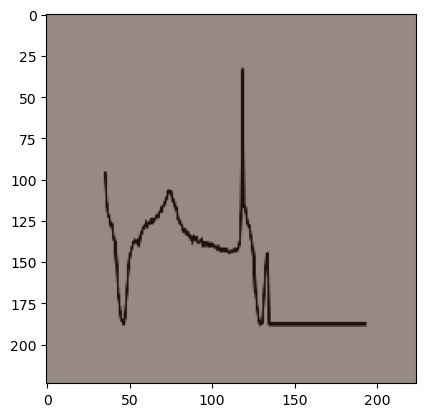

In [16]:
plt.imshow(test_images[0][0][3])

In [17]:
from tensorflow.keras.applications import ResNet50
pretrained_model = ResNet50(
                              input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet',
                              pooling='avg'
                              )

pretrained_model.trainable = False

In [18]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 23,858,630
Trainable params: 270,918
Non-t

In [19]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [20]:
model.compile(loss='categorical_crossentropy',optimizer='adam',
            metrics=['accuracy',
                     'Precision',
                     'Recall',
                     tf.keras.metrics.AUC(
                                    num_thresholds=200,
                                    curve="ROC",
                                    summation_method="interpolation",
                                    multi_label=False
                                    )])

In [21]:
%%time
result=model.fit(
    train_images,
    steps_per_epoch=3072//32,
    validation_data=val_images,
    validation_steps=768//32,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.2960 - accuracy: 0.4593 - precision: 0.7672 - recall: 0.1234 - auc: 0.8349
Epoch 1: val_accuracy improved from -inf to 0.61589, saving model to best_model.h5
96/96 [==============================] - 330s 3s/step - loss: 1.2960 - accuracy: 0.4593 - precision: 0.7672 - recall: 0.1234 - auc: 0.8349 - val_loss: 0.7599 - val_accuracy: 0.6159 - val_precision: 0.8875 - val_recall: 0.5443 - val_auc: 0.9565
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.7406 - precision: 0.8029 - recall: 0.5859 - auc: 0.9584
Epoch 2: val_accuracy improved from 0.61589 to 0.88411, saving model to best_model.h5
96/96 [==============================] - 315s 3s/step - loss: 0.6789 - accuracy: 0.7406 - precision: 0.8029 - recall: 0.5859 - auc: 0.9584 - val_loss: 0.4534 - val_accuracy: 0.8841 - val_precision: 0.9003 - val_recall: 0.8581 - val_auc: 0.9860
Epoch 3/10
96/96 [==============================] - E

In [22]:
from keras.models import load_model
best_model=load_model('best_model.h5')
results = best_model.evaluate(test_images, verbose=0)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
print("Test Precision: {:.4f}%".format(results[2] * 100))
print("   Test Recall: {:.4f}%".format(results[3] * 100))
print("      Test AUC: {:.4f}".format(results[4] ))

     Test Loss: 0.1799
 Test Accuracy: 94.1667%
Test Precision: 94.3574%
   Test Recall: 94.0625%
      Test AUC: 0.9962


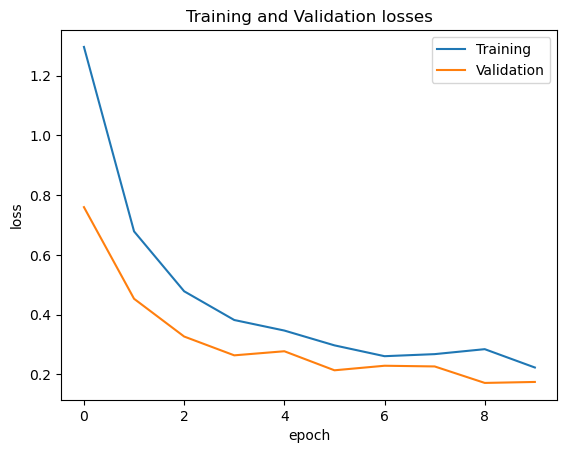

In [23]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

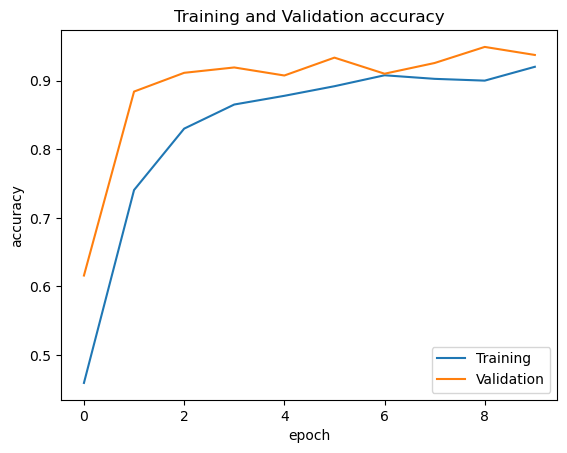

In [24]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')

In [25]:
y_pred = best_model.predict(test_images)
y_pred

30/30 [==============================] - 80s 3s/step


array([[3.44441347e-08, 9.93830144e-01, 4.34535876e-20, 6.33799920e-16,
        6.16920181e-03, 6.50200775e-07],
       [8.92202437e-01, 3.97461008e-06, 4.10542178e-08, 3.37371632e-04,
        1.28030579e-03, 1.06175959e-01],
       [4.70359286e-04, 7.62791497e-11, 1.21307252e-02, 9.81135130e-01,
        5.24613313e-08, 6.26380369e-03],
       ...,
       [8.83794487e-01, 1.42723241e-06, 1.90046805e-07, 9.22503066e-04,
        5.33589220e-04, 1.14747666e-01],
       [7.52948992e-09, 9.94213283e-01, 3.15499267e-21, 1.06559756e-16,
        5.78625081e-03, 5.19420610e-07],
       [2.97961918e-07, 4.13430378e-14, 9.85476434e-01, 1.45222889e-02,
        1.03171326e-11, 9.31041768e-07]], dtype=float32)

In [26]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 3, 3, 3, 1, 5, 1, 2, 2, 5, 3, 1, 2, 4, 4, 2, 4, 5, 2, 1, 3,
       4, 2, 4, 4, 4, 3, 2, 5, 3, 1, 2, 3, 2, 3, 4, 5, 4, 5, 0, 5, 1, 3,
       1, 4, 1, 4, 1, 0, 2, 2, 0, 3, 2, 0, 5, 0, 4, 0, 3, 5, 2, 5, 3, 0,
       5, 3, 1, 5, 1, 5, 5, 0, 5, 3, 0, 2, 0, 2, 0, 0, 4, 3, 2, 5, 2, 4,
       5, 5, 4, 5, 0, 1, 4, 2, 4, 1, 4, 2, 5, 2, 4, 5, 4, 4, 1, 0, 1, 4,
       2, 4, 4, 5, 2, 2, 2, 3, 3, 3, 0, 2, 4, 0, 1, 3, 4, 1, 1, 5, 4, 5,
       2, 4, 2, 0, 3, 3, 2, 0, 1, 2, 1, 3, 0, 0, 4, 3, 2, 1, 5, 3, 0, 4,
       1, 2, 1, 3, 0, 3, 3, 5, 5, 3, 1, 1, 4, 0, 3, 0, 5, 4, 1, 1, 0, 5,
       2, 5, 0, 2, 5, 0, 1, 3, 4, 4, 4, 1, 4, 2, 1, 4, 3, 4, 4, 4, 0, 0,
       5, 1, 5, 0, 5, 0, 1, 2, 0, 2, 4, 0, 0, 3, 0, 4, 2, 4, 1, 0, 5, 0,
       0, 0, 3, 2, 1, 2, 0, 5, 2, 4, 1, 2, 4, 0, 5, 2, 5, 0, 4, 1, 3, 2,
       4, 4, 0, 5, 0, 3, 2, 3, 2, 4, 2, 3, 4, 4, 3, 3, 0, 5, 4, 0, 2, 1,
       5, 1, 3, 2, 5, 5, 1, 0, 2, 5, 0, 2, 0, 1, 4, 5, 1, 4, 0, 0, 2, 3,
       3, 2, 0, 5, 4, 3, 1, 2, 1, 0, 1, 0, 5, 2, 3,

In [27]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)

report = classification_report(test_images.labels, y_pred, target_names=['F', 'M', 'N', 'Q', 'S', 'V'],digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)

report.to_csv('classification report.csv', index=True)

[[149   0   0   0   0  11]
 [  0 147   0   0  13   0]
 [  0   0 160   0   0   0]
 [  0   0   4 156   0   0]
 [  2   5   0   0 152   1]
 [ 19   0   0   1   0 140]]
              precision    recall  f1-score   support

           F     0.8765    0.9313    0.9030       160
           M     0.9671    0.9187    0.9423       160
           N     0.9756    1.0000    0.9877       160
           Q     0.9936    0.9750    0.9842       160
           S     0.9212    0.9500    0.9354       160
           V     0.9211    0.8750    0.8974       160

    accuracy                         0.9417       960
   macro avg     0.9425    0.9417    0.9417       960
weighted avg     0.9425    0.9417    0.9417       960



In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '20'
    
    
plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'],normalize=False,title='Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.rcParams['font.size'] = '16'
    
    
plot_confusion_matrix(cm, classes=['F', 'M', 'N', 'Q', 'S', 'V'],normalize=True,title='normalized Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('normalized confusion matrix' + '.jpg', dpi=500, bbox_inches = 'tight')